In [1]:
import os
import geopandas as gpd
import rioxarray
import rasterio
from rasterio.features import rasterize

os.getcwd()

'/home/jovyan/teaching/heat'

In [2]:
datafolder = "./data"
os.listdir(datafolder)

['osm_major_roads.gpkg',
 'bbox_simulation.gpkg',
 'osm_water.gpkg',
 'osm_railways_without_subway.gpkg',
 '.ipynb_checkpoints',
 'berlin.gpkg',
 'osm_subway.gpkg',
 'osm_forest.gpkg',
 'osm_green_without_forest.gpkg',
 'osm_buildings.gpkg',
 'T2M_daily_mean_max_topography_2011_2020_present_30.tif']

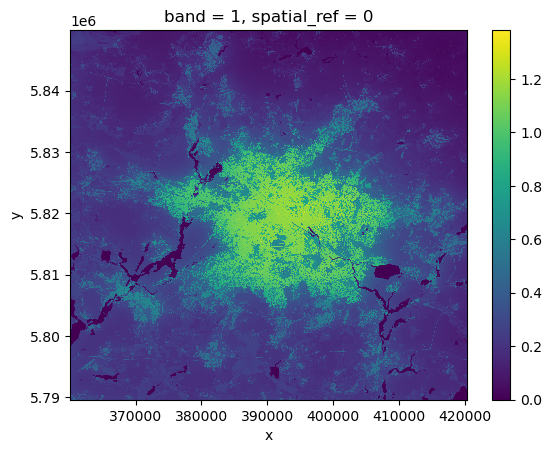

In [3]:
reference_raster = rioxarray.open_rasterio(datafolder + "/T2M_daily_mean_max_topography_2011_2020_present_30.tif")
reference_raster.plot()

In [4]:
ref_transform = reference_raster.rio.transform()
ref_crs = reference_raster.rio.crs
# print the CRS and transform to check
print("CRS of the reference raster:", ref_crs)
print("Transform of the reference raster:", ref_transform)



CRS of the reference raster: EPSG:32633
Transform of the reference raster: | 30.00, 0.00, 360092.00|
| 0.00,-30.00, 5849845.00|
| 0.00, 0.00, 1.00|


In [8]:
# load the datasets to rasterize - subset for prediction
railways = gpd.read_file(datafolder + "/osm_railways_without_subway.gpkg")
subway = gpd.read_file(datafolder + "/osm_subway.gpkg")
roads = gpd.read_file(datafolder + "/osm_major_roads.gpkg")
water = gpd.read_file(datafolder + "/osm_water.gpkg")
greens = gpd.read_file(datafolder + "/osm_green_without_forest.gpkg")
forest = gpd.read_file(datafolder + "/osm_forest.gpkg")
buildings = gpd.read_file(datafolder + "/osm_buildings.gpkg")

In [9]:
datasets = {
    "railways": railways,
    "subway": subway,
    "roads": roads,
    "water": water,
    "greens": greens,
    "forest": forest,
    "buildings": buildings
}
for name, dataset in datasets.items():
    # rasterize the dataset
    rasterized = rasterize(
        [(geom, 1) for geom in dataset.geometry],
        out_shape=reference_raster.shape[1:],
        transform=ref_transform,
        fill=0,
        all_touched=True
    )
    
    # write the rasterized dataset to a GeoTIFF file
    output_filename = os.path.join(datafolder, f"{name}_raster.tif")
    with rasterio.open(
        output_filename,
        'w',
        driver='GTiff',
        height=rasterized.shape[0],
        width=rasterized.shape[1],
        count=1,
        dtype=rasterized.dtype,
        crs=ref_crs,
        transform=ref_transform
    ) as dst:
        dst.write(rasterized, 1)
    print(f"Rasterized {name} and saved to {output_filename}")



Rasterized railways and saved to ./data/railways_raster.tif
Rasterized subway and saved to ./data/subway_raster.tif
Rasterized roads and saved to ./data/roads_raster.tif
Rasterized water and saved to ./data/water_raster.tif
Rasterized greens and saved to ./data/greens_raster.tif
Rasterized forest and saved to ./data/forest_raster.tif
Rasterized buildings and saved to ./data/buildings_raster.tif


In [16]:
import os
import geopandas as gpd
import rioxarray
import rasterio
from rasterio.features import rasterize
import numpy as np
from scipy.ndimage import convolve
from scipy.ndimage import distance_transform_edt


In [17]:
from customFunctions import writeRaster


In [18]:
help(writeRaster)

Help on function writeRaster in module customFunctions:

writeRaster(data, output_path, transform, crs)
    Write a numpy array to a GeoTIFF file.



In [19]:
# Define a function to compute distance to nearest feature
def compute_distance_to_nearest_feature(raster, feature_name):
    # Invert the raster to get the distance to the nearest feature
    inverted_raster = np.where(raster > 0, 0, 1)
    # Compute the distance transform
    distance_raster = distance_transform_edt(inverted_raster)
    # multiply by the grid size (30m) to convert to meters
    distance_raster *= 30  # Assuming each grid cell is 30m x 30m
    # Save the distance raster to a new GeoTIFF file
    output_filename = os.path.join(datafolder, f"distance_to_nearest_{feature_name}.tif")
    crs = raster.rio.crs
    transform = raster.rio.transform()
    writeRaster(distance_raster, output_filename, crs=crs, transform=transform)

def compute_convolution(raster, feature_name, kernel_size=33):
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / (kernel_size * kernel_size)
    # Perform convolution with the defined kernel
    convolved_raster = convolve(raster, kernel, mode='constant', cval=0.0)
    #convolved_datasets[name] = convolved_raster
    # Save the convolved raster to a new GeoTIFF file
    output_filename = os.path.join(datafolder, f"{feature_name}_convolved_{kernel_size*30}m.tif")
    crs = raster.rio.crs
    transform = raster.rio.transform()
    writeRaster(convolved_raster, output_filename, crs=crs, transform=transform)


In [20]:
# Load the rasterized datasets, and ensure they are in float32 format
greens_raster = rioxarray.open_rasterio(os.path.join(datafolder, "greens_raster.tif")).squeeze().astype(np.float32)
forest_raster = rioxarray.open_rasterio(os.path.join(datafolder, "forest_raster.tif")).squeeze().astype(np.float32)
water_raster = rioxarray.open_rasterio(os.path.join(datafolder, "water_raster.tif")).squeeze().astype(np.float32)
railways_raster = rioxarray.open_rasterio(os.path.join(datafolder, "railways_raster.tif")).squeeze().astype(np.float32)
subway_raster = rioxarray.open_rasterio(os.path.join(datafolder, "subway_raster.tif")).squeeze().astype(np.float32)
roads_raster = rioxarray.open_rasterio(os.path.join(datafolder, "roads_raster.tif")).squeeze().astype(np.float32)
buildings_raster = rioxarray.open_rasterio(os.path.join(datafolder, "buildings_raster.tif")).squeeze().astype(np.float32)

# loop through the datasets, compute the convolution and save them
datasets = {
    "greens": greens_raster,
    "forest": forest_raster,
    "water": water_raster,
    "railways": railways_raster,
    "subway": subway_raster,
    "roads": roads_raster,
    "buildings": buildings_raster
}

# Loop through the datasets and compute distance to / density of
# greens, forest, water, railways, subway, roads and buildings
for name, raster in datasets.items():
    compute_distance_to_nearest_feature(raster, name)
    compute_convolution(raster, name)


Saved file ./data/distance_to_nearest_greens.tif
Saved file ./data/greens_convolved_990m.tif
Saved file ./data/distance_to_nearest_forest.tif
Saved file ./data/forest_convolved_990m.tif
Saved file ./data/distance_to_nearest_water.tif
Saved file ./data/water_convolved_990m.tif
Saved file ./data/distance_to_nearest_railways.tif
Saved file ./data/railways_convolved_990m.tif
Saved file ./data/distance_to_nearest_subway.tif
Saved file ./data/subway_convolved_990m.tif
Saved file ./data/distance_to_nearest_roads.tif
Saved file ./data/roads_convolved_990m.tif
Saved file ./data/distance_to_nearest_buildings.tif
Saved file ./data/buildings_convolved_990m.tif


In [21]:
from customFunctions import slice_into_tiles, save_tiles_as_geotiff, save_stacked_raster_as_geotiff


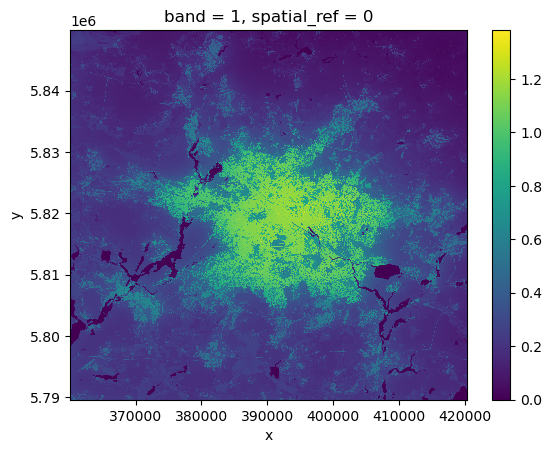

In [22]:
heat_raster = reference_raster.copy().squeeze()
heat_raster.plot()

In [23]:
# load the convolved feature rasters
greens_convolved= rioxarray.open_rasterio(os.path.join(datafolder, "greens_convolved_990m.tif")).squeeze()
forest_convolved= rioxarray.open_rasterio(os.path.join(datafolder, "forest_convolved_990m.tif")).squeeze()
water_convolved= rioxarray.open_rasterio(os.path.join(datafolder, "water_convolved_990m.tif")).squeeze()
railways_convolved= rioxarray.open_rasterio(os.path.join(datafolder, "railways_convolved_990m.tif")).squeeze()
subway_convolved= rioxarray.open_rasterio(os.path.join(datafolder, "subway_convolved_990m.tif")).squeeze()
roads_convolved= rioxarray.open_rasterio(os.path.join(datafolder, "roads_convolved_990m.tif")).squeeze()
buildings_convolved= rioxarray.open_rasterio(os.path.join(datafolder, "buildings_convolved_990m.tif")).squeeze()

# load the distance feature rasters
greens_distance = rioxarray.open_rasterio(os.path.join(datafolder, "distance_to_nearest_greens.tif")).squeeze()
forest_distance = rioxarray.open_rasterio(os.path.join(datafolder, "distance_to_nearest_forest.tif")).squeeze()
water_distance = rioxarray.open_rasterio(os.path.join(datafolder, "distance_to_nearest_water.tif")).squeeze()
railways_distance = rioxarray.open_rasterio(os.path.join(datafolder, "distance_to_nearest_railways.tif")).squeeze()
subway_distance = rioxarray.open_rasterio(os.path.join(datafolder, "distance_to_nearest_subway.tif")).squeeze()
roads_distance = rioxarray.open_rasterio(os.path.join(datafolder, "distance_to_nearest_roads.tif")).squeeze()
buildings_distance = rioxarray.open_rasterio(os.path.join(datafolder, "distance_to_nearest_buildings.tif")).squeeze()

# stack them all, with heat as the first layer
stacked_raster = np.stack([heat_raster, greens_convolved, forest_convolved,
                           water_convolved, railways_convolved, subway_convolved,
                           roads_convolved, buildings_convolved,
                           greens_distance, forest_distance, water_distance,
                           railways_distance, subway_distance, roads_distance,
                           buildings_distance], axis=0)
stacked_raster.shape # should be (15, height, width) where 15 is the number of layers


(15, 2007, 2007)

In [24]:
# slice the stacked raster into 4 tiles, using the provided custom function
tile_size = stacked_raster.shape[1] // 2  # Assuming we want 2x2 tiles
tiles = slice_into_tiles(stacked_raster, tile_size)
tiles.shape

# the geolocation of the tiles is based on the original raster's transform and CRS
# but we need to adjust the transform for each tile
output_folder = os.path.join(datafolder, "tiles")
save_tiles_as_geotiff(tiles, heat_raster.rio.transform(), heat_raster.rio.crs, output_folder)

# alternative version: save full stacked raster as a single GeoTIFF
output_filename = os.path.join(datafolder, "stacked_raster.tif")
save_stacked_raster_as_geotiff(stacked_raster, heat_raster.rio.transform(), heat_raster.rio.crs, output_filename)

Saved tile 0 to ./data/tiles/tile_0.tif
Saved tile 1 to ./data/tiles/tile_1.tif
Saved tile 2 to ./data/tiles/tile_2.tif
Saved tile 3 to ./data/tiles/tile_3.tif
Saved stacked raster to ./data/stacked_raster.tif


In [25]:
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Import custom functions from another Python script in the same folder
from customFunctions import readRaster, writeRaster, plotSideBySide, plotSpatialError


In [26]:
os.getcwd()

'/home/jovyan/teaching/heat'

In [27]:
data, transform, crs, height, width = readRaster(os.path.join(datafolder, "tiles/tile_0.tif"))
training_data = data.reshape(data.shape[0], -1).T  # Reshape to (num_pixels, num_layers)

In [28]:
training_data.shape

(1006009, 15)

In [29]:
heat_layer = training_data[:, 0]  # First layer is heat
features = training_data[:, 1:]   # Remaining layers are features

# Randomly select a fraction of the pixels for training, e.g. 0.1 for 10%
fraction = 0.10
num_pixels = features.shape[0]
sample_size = int(num_pixels * fraction)
random_indices = random.sample(range(num_pixels), sample_size)
X_sample = features[random_indices]    # the predictors (features)
y_sample = heat_layer[random_indices]  # the target variable (heat layer)

# Split the sample into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)


In [30]:
import pandas as pd
param_grid = {'n_estimators': [10, 20, 30, 40, 50],
              'max_depth': [None],
              'n_jobs': [-1]}  # Use all available cores
# Create a Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)
# print the ranking of estimators with hyperparameters and skill score as table
results = pd.DataFrame(grid_search.cv_results_)
print(results[['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score'))


                                              params  mean_test_score  \
4  {'max_depth': None, 'n_estimators': 50, 'n_job...         0.927247   
3  {'max_depth': None, 'n_estimators': 40, 'n_job...         0.926776   
2  {'max_depth': None, 'n_estimators': 30, 'n_job...         0.926233   
1  {'max_depth': None, 'n_estimators': 20, 'n_job...         0.924825   
0  {'max_depth': None, 'n_estimators': 10, 'n_job...         0.920658   

   rank_test_score  
4                1  
3                2  
2                3  
1                4  
0                5  


In [22]:
from customFunctions import plotSideBySide, plotSpatialError

In [31]:

def plotSideBySide(original, predicted, title1="Original", title2="Predicted"):
    """Plot two images side by side, using the same color scale."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(title1)
    plt.imshow(original, cmap='hot', vmin=np.min(original), vmax=np.max(original), interpolation='nearest')
    plt.colorbar(label='Heat Value')
    
    plt.subplot(1, 2, 2)
    plt.title(title2)
    plt.imshow(predicted, cmap='hot', vmin=np.min(original), vmax=np.max(original), interpolation='nearest')
    plt.colorbar(label='Heat Value')
    
    plt.tight_layout()
    plt.show()

def plotSpatialError(original, predicted):
    """Plot the spatial error between original and predicted heat layers."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Absolute Difference")
    plt.imshow((predicted - original), cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Units of target variable')

    plt.subplot(1, 2, 2)
    plt.title("Percentage Difference")
    plt.imshow(((predicted - original) / original * 100), cmap='coolwarm', vmin=-100, vmax=100, interpolation='nearest')
    plt.colorbar(label='Percentage (%)')

    plt.tight_layout()
    plt.show()


Model R^2 score: 0.9241


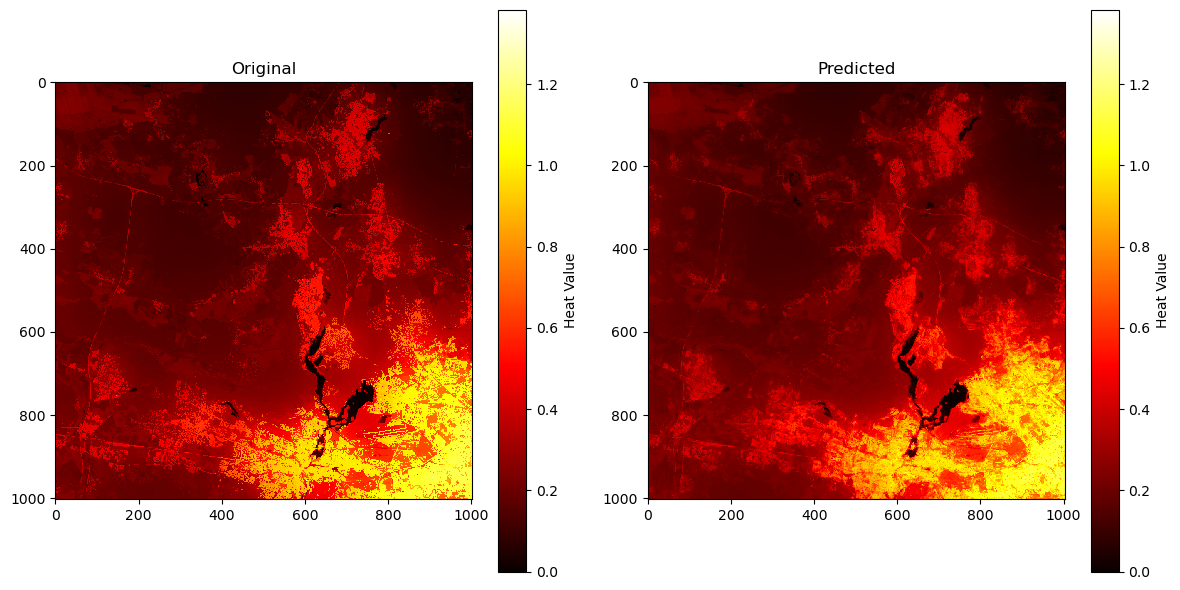

/tmp/ipykernel_2650/1189814859.py:27: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(((predicted - original) / original * 100), cmap='coolwarm', vmin=-100, vmax=100, interpolation='nearest')
/tmp/ipykernel_2650/1189814859.py:27: RuntimeWarning: invalid value encountered in divide
  plt.imshow(((predicted - original) / original * 100), cmap='coolwarm', vmin=-100, vmax=100, interpolation='nearest')


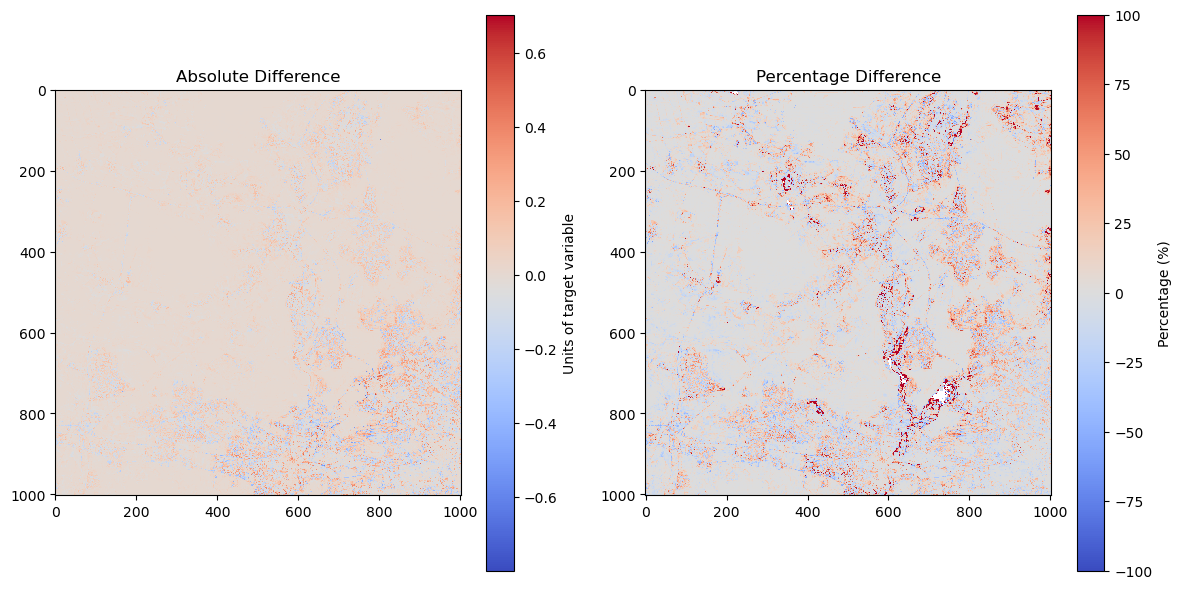

In [32]:
model = RandomForestRegressor(n_estimators=10, max_depth=None, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(f"Model R^2 score: {score:.4f}")
# predict the heat layer using the model
predicted_heat = model.predict(features)
# reshape the predicted heat back to the original tile shape
predicted_heat_reshaped = predicted_heat.reshape(height, width)
# use the custom function to plot the original and predicted heat layers side by side
plotSideBySide(data[0], predicted_heat_reshaped)
plotSpatialError(data[0], predicted_heat_reshaped)


In [33]:
import joblib

output_path = os.path.join(datafolder, "predicted_heat_tile_0_rf.tif")
writeRaster(predicted_heat_reshaped, output_path, transform, crs)
# save the fitted model to a file
model_path = os.path.join(datafolder, "random_forest_model.pkl")
joblib.dump(model, model_path)


Saved file ./data/predicted_heat_tile_0_rf.tif


['./data/random_forest_model.pkl']

Mean Squared Error for Tile 1: 0.0244
R^2 Score for Tile 1: 0.7415


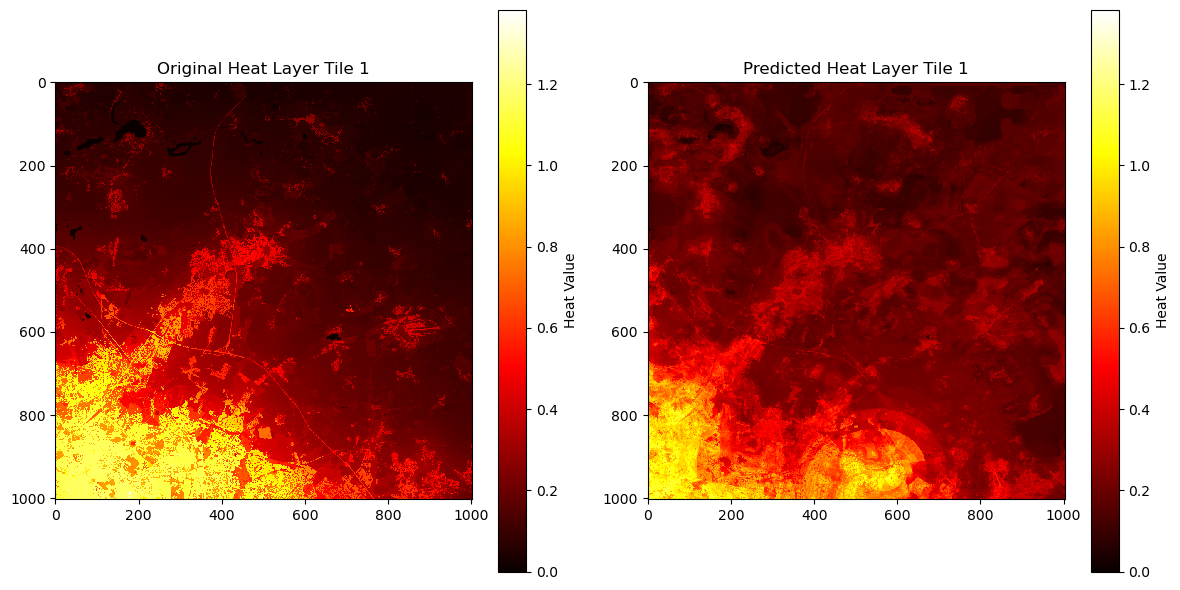

/tmp/ipykernel_2650/1189814859.py:27: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(((predicted - original) / original * 100), cmap='coolwarm', vmin=-100, vmax=100, interpolation='nearest')


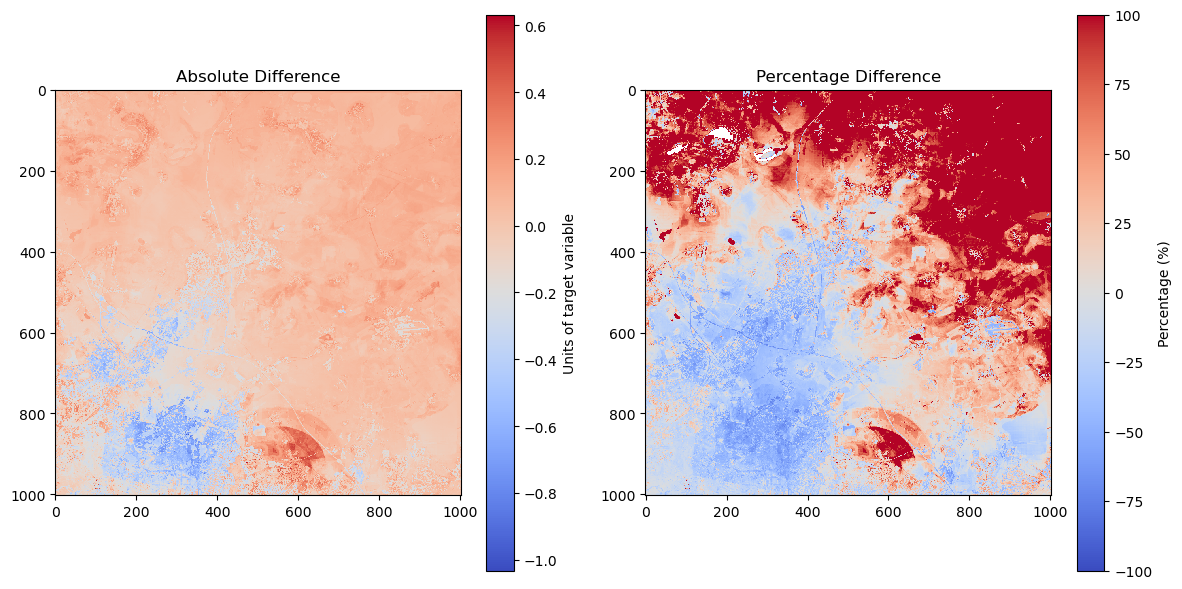

In [34]:
tile_path_1 = os.path.join(datafolder, "tiles/tile_1.tif")
tile_1, transform_1, crs_1, height_1, width_1 = readRaster(tile_path_1)
tile_data_reshaped_1 = tile_1.reshape(tile_1.shape[0], -1).T  # (num_pixels, num_layers)
predicted_heat_tile_1 = model.predict(tile_data_reshaped_1[:, 1:])  # Use features only
predicted_heat_reshaped_1 = predicted_heat_tile_1.reshape(height_1, width_1)
# evaluate the model on tile 1
mse = mean_squared_error(tile_1[0].flatten(), predicted_heat_reshaped_1.flatten())
r2 = r2_score(tile_1[0].flatten(), predicted_heat_reshaped_1.flatten())
print(f"Mean Squared Error for Tile 1: {mse:.4f}")
print(f"R^2 Score for Tile 1: {r2:.4f}")
# plot the original and predicted heat layers side by side
plotSideBySide(tile_1[0], predicted_heat_reshaped_1, title1="Original Heat Layer Tile 1", title2="Predicted Heat Layer Tile 1")
plotSpatialError(tile_1[0], predicted_heat_reshaped_1)


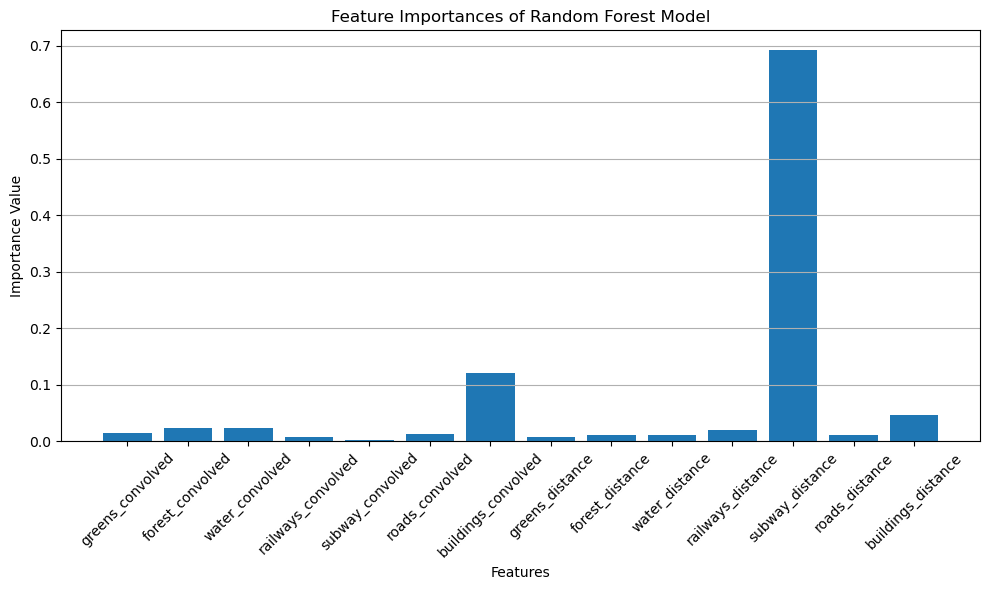

In [35]:
features_names = ['greens_convolved', 'forest_convolved', 'water_convolved',
                  'railways_convolved', 'subway_convolved', 'roads_convolved',
                  'buildings_convolved', 'greens_distance', 'forest_distance',
                  'water_distance', 'railways_distance', 'subway_distance',
                  'roads_distance', 'buildings_distance']

# Visualize the feature importances
feature_importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xticks(range(len(feature_importances)), features_names, rotation=45)
plt.title("Feature Importances of Random Forest Model")
plt.xlabel("Features")
plt.ylabel("Importance Value")
plt.grid(axis='y')
plt.tight_layout()


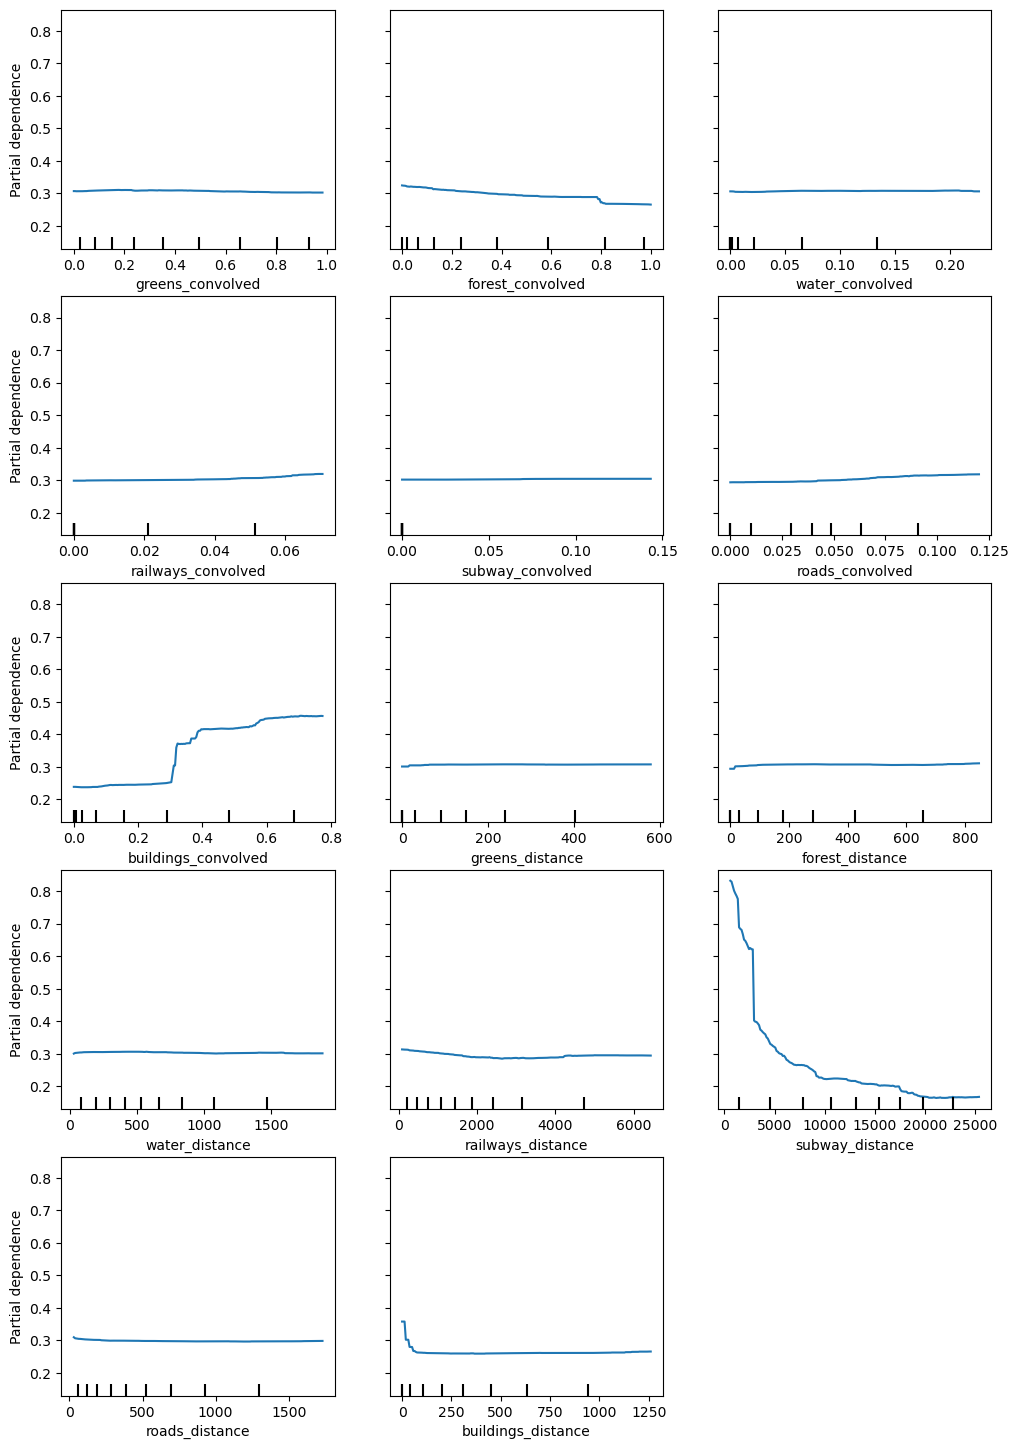

In [37]:
fig, ax = plt.subplots(figsize=(12, 18))
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    features=range(len(features_names)),
    feature_names=features_names,
    ax=ax,
    grid_resolution=200
)

In [38]:
from customFunctions import predictHeatLayer
help(predictHeatLayer) # check the docstring of the function

Help on function predictHeatLayer in module customFunctions:

predictHeatLayer(input_path, model, output_path, features_only=False)
    Predict the heat layer from a GeoTIFF tile using a trained model.
    This function assumes the first layer is the target (heat) layer and the remaining layers are features.
    If a raster stack without a heat layer is provided, set features_only=True.



In [39]:
rf_model = joblib.load(os.path.join(datafolder, "random_forest_model.pkl"))
predictHeatLayer(datafolder + "/stacked_raster.tif", rf_model, datafolder + "/prediction_subset.tif")

Saved file ./data/prediction_subset.tif
